In [2]:
import sys
sys.path.append('../')
from ns_2d_vorticity_spetral_solver import *
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from utils import anim_2D

name_device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(name_device)
print('device:\t', name_device)

/home/yichen/anaconda3/envs/test/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/yichen/anaconda3/envs/test/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


device:	 cuda


## Intro
2D NS Vorticity:

$$
\partial_t w + \textbf{u}\cdot\nabla w = \nu\Delta w + f
$$

For 2D NS Vorticity dataset, a simple way to generate similar datasets are:

$$
\text{dt} \rightarrow k \ \text{dt}, \ w \rightarrow \frac{w}{k}, \ \nu \rightarrow \frac{\nu}{k}, \ f \rightarrow \frac{f}{k^2}
$$

In [3]:
# Data Preperation
data_f = h5py.File('../data/ns_exp1/ns_random_visc=0.0001_s=256_steps=200_T=5.0_dt=0.0001_N=4.h5', 'r')
a = np.array(data_f['a'][0])
u = np.array(data_f['u'][0])
visc = np.array(data_f['mu'][0])
f = np.array(data_f['f'][0])
dt = np.float32(data_f['dt'][0])
T = np.array(data_f['total_time'][0])
record_steps = u.shape[-1]
s = a.shape[0]

print(a.shape, u.shape, f.shape, visc, dt, T, s)

(256, 256) (256, 256, 200) (256, 256) 1e-04 1e-04 5.0 256


The solver requires 4 arguments: total_time, delta_t, record_steps, resolution

While the deep learning model would take the prediction time step as total_time / record_steps;
the numeric simulation would still use the delta_t for each updation (record a frame every [(total_time / delta_t) / record_steps] updations).

According to the Courant theory, the advection stable time step is max_courant_number * dx / max_velocity, while the diffusion stable time step is dx ^ 2 / (viscosity * 2 ^ ndim), which means both should scale by k. So scaling dt by k is also reasonable in numerical analysis.

Therefore, if we need to generate a similiar dataset with scaling factor k, then for total_time, it needs to be total_time* k; for delta_t, it needs to be delta_t *k; for record_steps and resolution, no change.

In [4]:
# Assign a value to k
int0 = 4.
k1=int0
k2=1/int0

There are ways to generate (because the numerical errors might be different).

For example, if one dataset have the initial values $w_0$, and total time steps T:

### Method 1. 
Directly transform the dataset linearly.

This method is not necessarily numerically congruent! Actually, this would make the simulation preciser (it can be viewed as the calculation numbers between every 2 adjacent frames times by k).

In [5]:
u1 = u / k1
visc1 = visc / k1
f1 = f / k1**2

### Method 2. 
For each $t_0$ above, we record the correspondent w as initial value, and throw them back to the data generator with quantities transformed as above.

This method is numerically congruent in theory, all errors may come from the truncation error for multipilcations and additions, and amplified by fourier transforms. But as it turns out, the error remains below 2e-07 (relative error) even after 1000 large steps, so we can assume the data generated by method 1 can simulate any data generated by method 2 with the same generating coefficient.

Here $T \rightarrow k\ T$ to scale the total time.

In [6]:
a2 = u1[..., 0]
visc2 = visc / k1
T2 = T * k1
dt2 = k1 * dt
record_steps2 = record_steps
f2 = f / (k1*k1)

solver = NS_2D_Vorticity_Solver(resolution=s, device=device)

a2 = torch.from_numpy(a2).unsqueeze(0).to(device)
f2 = torch.from_numpy(f2).to(device)

u2, _ = solver.solve_navier_stokes_2d_const_force(a2, visc2, T2, dt2, record_steps2, force=f2)
u2 = u2[0]
a2 = a2.unsqueeze(-1).squeeze(0).cpu().numpy()
u2 = np.concatenate([a2, u2], axis=-1)
u2 = u2[..., :-1]

100%|██████████| 50001/50001 [00:10<00:00, 4767.14it/s]


In [18]:
i=-1
np.sum(np.abs(u1[..., i]-u2[..., i])) / np.sum(np.abs(u1[..., i]))

1.5678143e-07

In [15]:
np.sum(np.abs(u1-u2))

0.1684981

The solver below simulates the FNO solver.

for the original solver, it simulates the solver where:
$$
w_{t+\Delta t} \approx w_t + \Delta t [\textbf{u}\cdot\nabla w = \nu\Delta w + f] 
$$
In the traditional numerical solver, $\Delta t = \frac{T}{N}dt$ (N is record step), so we should keep this quantity the same;

dt isn't an important quantity here, since it only affect the accuracy of the solver.


We would find that if we want to predict the transformed dataset:
$$
w'_{t+\Delta' t} \approx w'_t + \Delta' t [\textbf{u'}\cdot\nabla w' = \nu\Delta w' + f'] 
$$
where $\Delta' t= k \Delta t$, then we would need k continuous steps of predictions to simulate the transformed outcome.

So, given the original dataset with record step N, we can generate another similar dataset with record step N.

In [ ]:
a3 = u1[..., 0]
visc3 = visc / k1
T3 = T * k1
dt3 = dt
record_steps3 = int(record_steps * k1)
f3 = f / (k1*k1)

solver = NS_2D_Vorticity_Solver(resolution=s, device=device)

a3 = torch.from_numpy(a3).unsqueeze(0).to(device)
f3 = torch.from_numpy(f3).to(device)

u3, _ = solver.solve_navier_stokes_2d_const_force(a3, visc3, T3, dt3, record_steps3, force=f3)
u3 = u3[0]
a3 = a3.unsqueeze(-1).squeeze(0).cpu().numpy()
u3 = np.concatenate([a3, u3], axis=-1)
u3 = u3[..., :-1]

In [38]:
np.sum(np.abs(u1-u3[..., ::4]))

3134.0376

Then, what about, say, scale the dataset by k2=1/int0?
$$
w'_{t+\Delta' t} \approx w'_t + \Delta' t [\textbf{u'}\cdot\nabla w' = \nu\Delta w' + f'] 
$$
In this case, $int_0 \Delta' t =  \Delta t$, so for a simulation step, the outcome should be approximately the next forth step of the transformed dataset.

So, given the original dataset with record step N, we can generate another int0 similar datasets with record step N // int0.

In [39]:
p=int0
u4 = u * p
visc4 = visc * p
f4 = f * p**2

In [42]:
a5 = u4[..., 0]
visc5 = visc * p
T5 = T / p
dt5 = dt / p
record_steps5 = int(record_steps / p)
f5 = f * (p*p)

solver = NS_2D_Vorticity_Solver(resolution=s, device=device)

a5 = torch.from_numpy(a5).unsqueeze(0).to(device)
f5 = torch.from_numpy(f5).to(device)

u5, _ = solver.solve_navier_stokes_2d_const_force(a5, visc5, T5, dt5, record_steps5, force=f5)
u5 = u5[0]
a5 = a5.unsqueeze(-1).squeeze(0).cpu().numpy()
u5 = np.concatenate([a5, u5], axis=-1)
u5 = u5[..., :-1]

  0%|          | 0/50001 [00:00<?, ?it/s]

100%|██████████| 50001/50001 [00:10<00:00, 4727.27it/s]


In [43]:
np.sum(np.abs(u5-u4[..., ::4]))

0.6621637

In [69]:
import sys
sys.path.append('../')
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from utils import anim_2D

# data_f = h5py.File('../data/ns_contextual/ns_random_forces_mini.h5', 'r')
# u0 = np.array(data_f['test']['a'][0])
# u = np.array(data_f['test']['u'][0])

data_f1 = h5py.File('../data/ns_exp1/ns_random_visc=0.0001_s=256_steps=200_T=5.0_dt=0.0001_N=4.h5', 'r')
u1 = np.array(data_f1['u'][0])
data_f2 = h5py.File('../data/ns_exp1/ns_random_visc=0.0001_s=256_steps=200_T=5.0_dt=0.0005_N=4.h5', 'r')
u2 = np.array(data_f2['u'][0])

In [71]:
i=4
np.sum(np.abs(u2[..., i]-u1[..., i]))

0.33513868

Data stats - Max: 2.752144 Min: -1.6516817 Mean: -1.0430813e-08


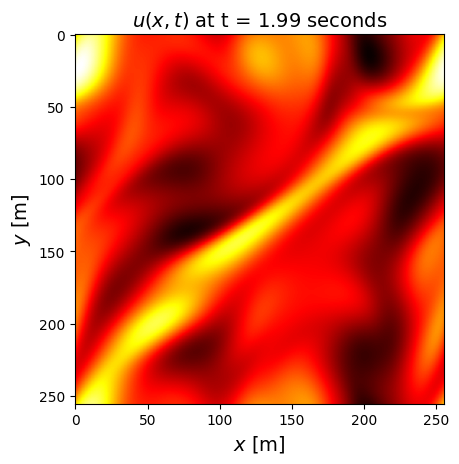

In [7]:
import sys
sys.path.append('../')
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from utils import anim_2D

# data_f = h5py.File('../data/ns_contextual/ns_random_forces_mini.h5', 'r')
# u0 = np.array(data_f['test']['a'][0])
# u = np.array(data_f['test']['u'][0])

data_f = h5py.File('../data/ns_exp1/ns_random_visc=0.0001_s=256_steps=200_T=5.0_dt=0.0001_N=4.h5', 'r')
u0 = np.array(data_f['a'][0])
u = np.array(data_f['u'][0])

anim_2D(data=u, dt=0.01, save_path='../video/dt_1e-4.mp4')

Data stats - Max: 2.7519999 Min: -1.6529448 Mean: -2.719462e-08


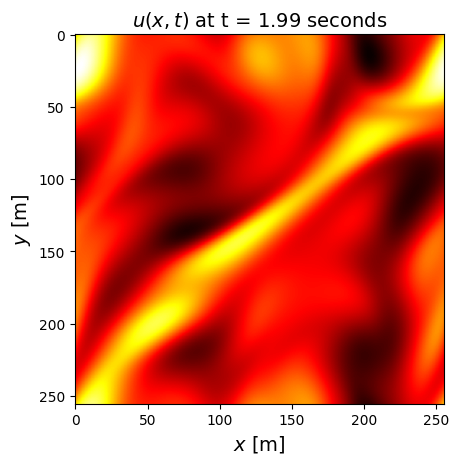

In [8]:
import sys
sys.path.append('../')
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from utils import anim_2D

# data_f = h5py.File('../data/ns_contextual/ns_random_forces_mini.h5', 'r')
# u0 = np.array(data_f['test']['a'][0])
# u = np.array(data_f['test']['u'][0])

data_f = h5py.File('../data/ns_exp1/ns_random_visc=0.0001_s=256_steps=200_T=5.0_dt=0.001_N=4.h5', 'r')
u0 = np.array(data_f['a'][0])
u = np.array(data_f['u'][0])

anim_2D(data=u, dt=0.01, save_path='../video/dt_1e-3.mp4')

In [4]:
import h5py

data_f = h5py.File('../data/ns_contextual/ns_random_forces_mini.h5', 'r')

print("Objects in the HDF5 file:")
for name in data_f:
    print(name)
    for dataset_name in data_f[name]:
        dataset = data_f[name][dataset_name]
        print(dataset_name, dataset.shape)  # 打印数据集名称和形状

Objects in the HDF5 file:
test
a (50, 256, 256)
f (50, 256, 256)
mu (50,)
u (50, 256, 256, 200)
train
a (100, 256, 256)
f (100, 256, 256)
mu (100,)
u (100, 256, 256, 200)
valid
a (50, 256, 256)
f (50, 256, 256)
mu (50,)
u (50, 256, 256, 200)


In [6]:
np.array(data_f['test']['mu'])

array([2.1520658e-05, 3.7136597e-05, 6.9595699e-05, 4.1354175e-05,
       7.4304793e-05, 1.5182613e-05, 7.1173818e-05, 9.1583323e-05,
       4.4746532e-05, 4.5386154e-05, 4.8900285e-05, 7.9248864e-05,
       6.6460059e-05, 8.1419486e-05, 5.4801545e-05, 3.2794502e-05,
       2.4625328e-05, 5.2284577e-05, 3.5268593e-05, 8.5046180e-05,
       7.8836143e-05, 2.2082138e-05, 6.5803055e-05, 3.8981525e-05,
       4.8558675e-05, 3.8700466e-05, 9.8313052e-05, 2.0054611e-05,
       3.7730199e-05, 3.8167640e-05, 5.3039788e-05, 2.6134916e-05,
       2.8612434e-05, 1.3729929e-05, 5.4998389e-05, 7.1916307e-05,
       6.3741885e-05, 4.8638707e-05, 3.6533373e-05, 8.9673267e-05,
       7.3187373e-05, 6.0055587e-05, 1.1805843e-05, 9.8296136e-05,
       2.9254779e-05, 9.3011258e-05, 7.1135895e-05, 2.5594285e-05,
       1.2366012e-05, 6.4945816e-05], dtype=float32)

In [2]:
import numpy as np
u0 = np.array(data_f['test']['a'][0])
u = np.array(data_f['test']['u'][0])

In [3]:
u.shape

(256, 256, 200)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ..utils import anim_2D

anim_2D(data=u, dt=0.01, save_path='./video/test.mp4', show=True)

plt.show()

ImportError: attempted relative import with no known parent package

In [ ]:
import numpy as np

a0 = data_f['test']['a']
u = data_f['test']['u']
